In [3]:
import _init_paths
import tensorflow as tf
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, sys, cv2
import argparse
from six.moves import xrange
from networks.factory import get_network
os.environ["CUDA_VISIBLE_DEVICES"]="6"

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


#CLASSES = ('__background__','person','bike','motorbike','car','bus')

def vis_detections(im, class_name, dets,ax, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    #im_file = os.path.join('/home/corgi/Lab/label/pos_frame/ACCV/training/000001/',image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print (('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')

    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, ax, thresh=CONF_THRESH)

def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Faster R-CNN demo')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU device id to use [0]',
                        default=0, type=int)
    parser.add_argument('--cpu', dest='cpu_mode',
                        help='Use CPU mode (overrides --gpu)',
                        action='store_true')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16]',
                        default='VGGnet_test')
    parser.add_argument('--model', dest='model', help='Model path',
                        default=' ')
    
    args = parser.parse_args(['--model', '../model/demo/VGGnet_fast_rcnn_iter_70000.ckpt'])

    return args

Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/rpn_conv/3x3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/rpn_cls_score:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("rpn_cls_prob_reshape:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_bbox_pred/rpn_bbox_pred:0", shape=(?, ?, ?, 36), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rois:0", shape=(?, 5), dtype=float32)
[<tf.Tensor 'conv5_3/conv5_3:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'rois:0' shape=(?, 5) dtype=float32>]
Tensor("fc7/fc7:0", shape=(?, 4096), dtype=float32)
INFO:tensorflow:Restoring parameters from ../model/demo/VGGnet_fast_rcnn_iter_70000.ckpt


Loaded network ../model/demo/VGGnet_fast_rcnn_iter_70000.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

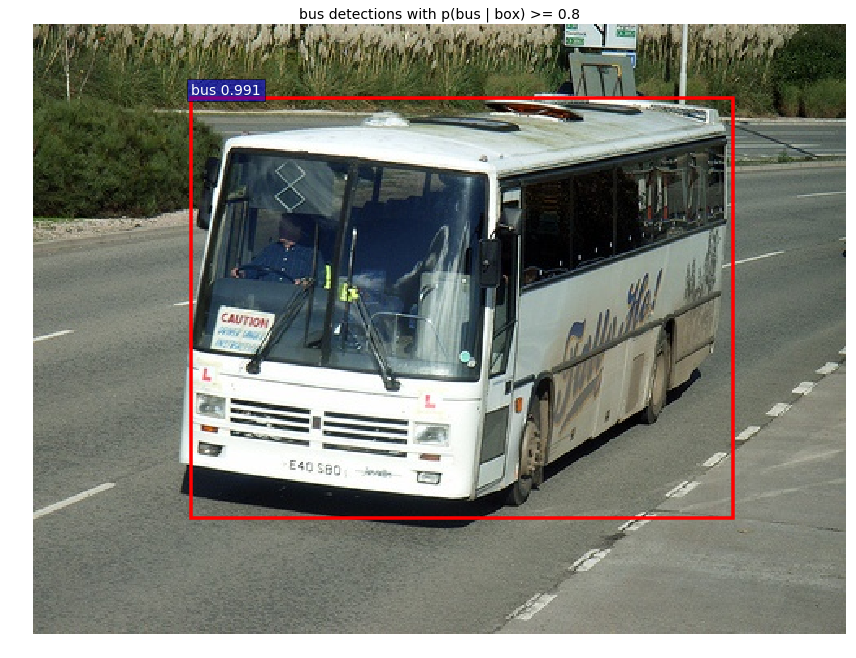

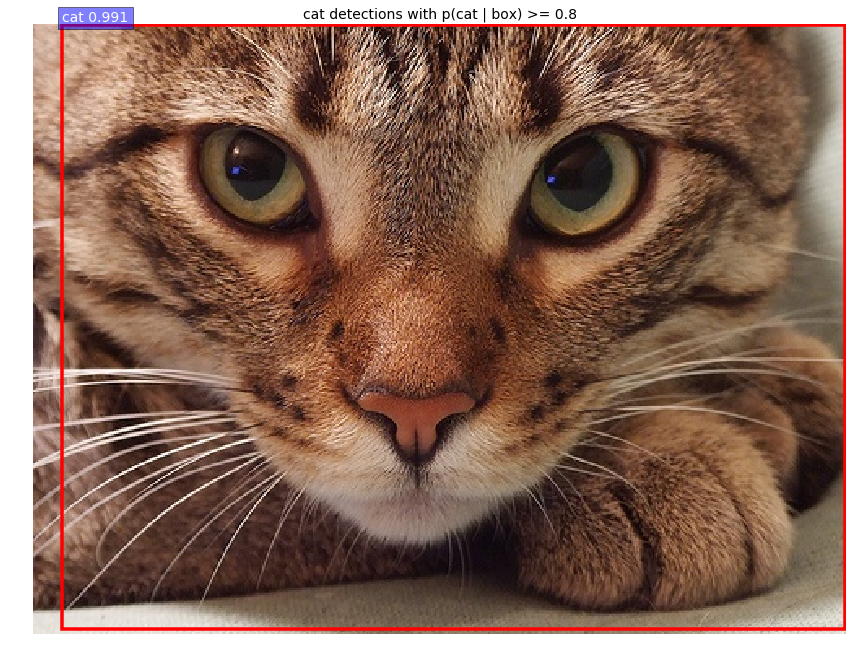

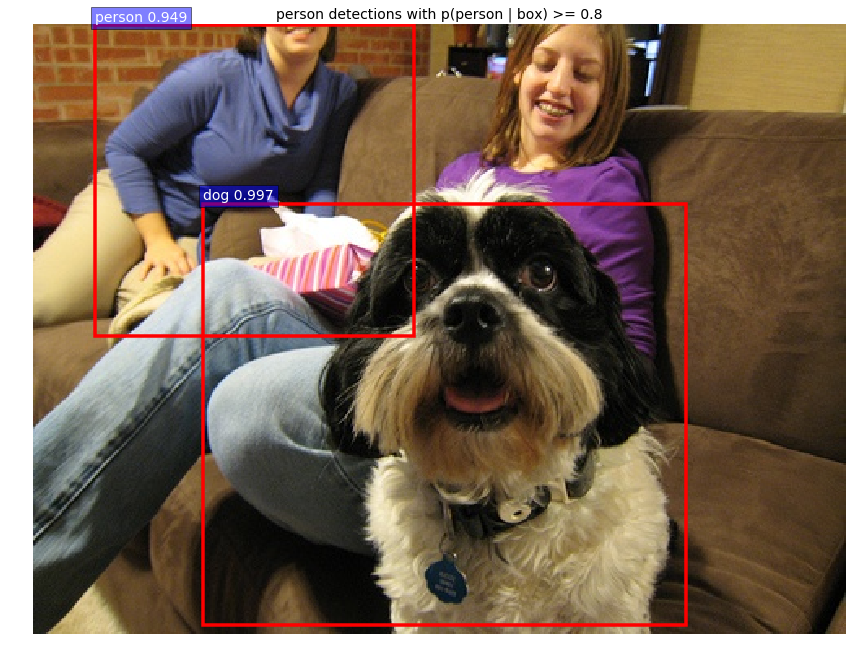

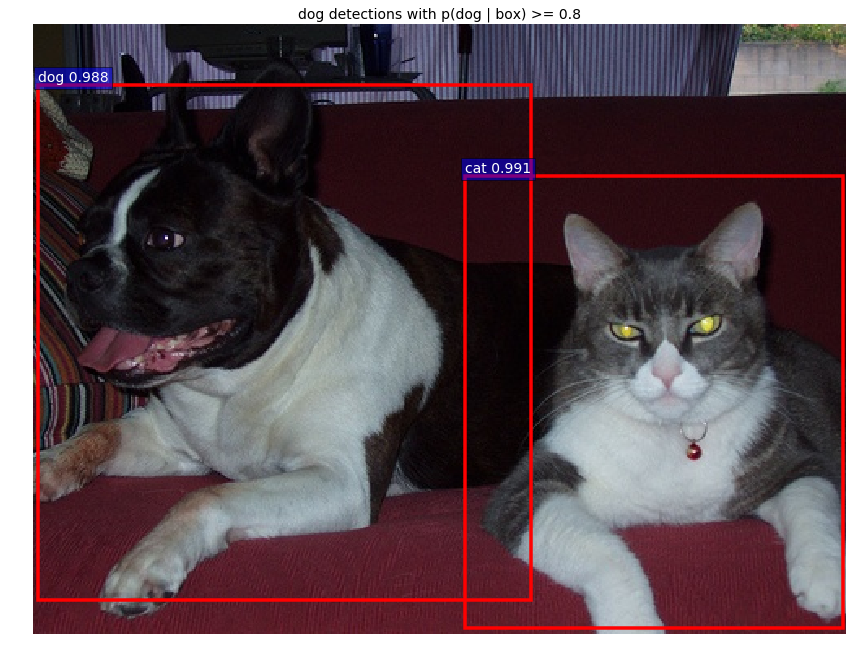

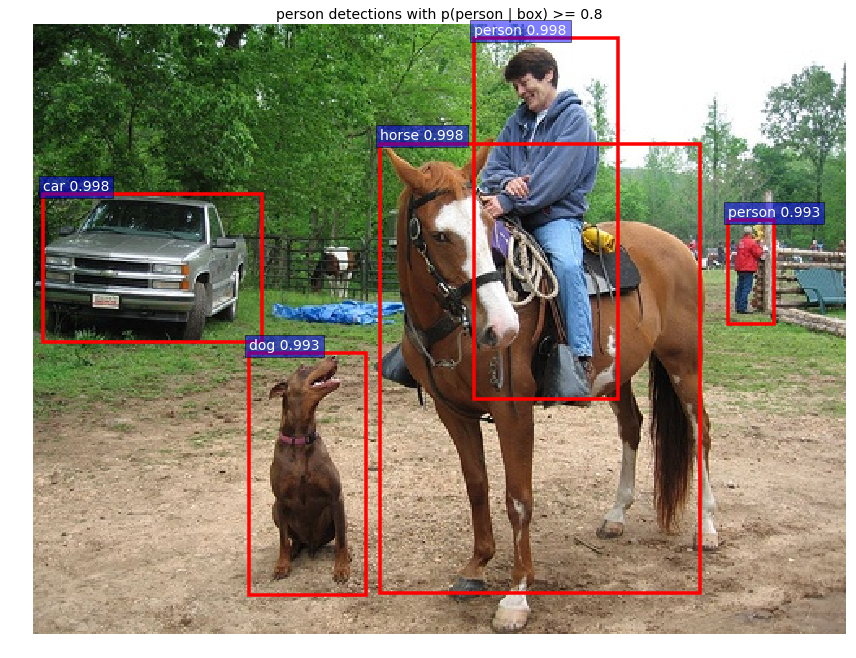

In [4]:

cfg.TEST.HAS_RPN = True  # Use RPN for proposals

args = parse_args()
# args.model='../model/demo/VGGnet_fast_rcnn_iter_70000.ckpt'

if args.model == ' ':
    raise IOError(('Error: Model not found.\n'))

# init session
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
# load network
net = get_network(args.demo_net)
# load model
saver = tf.train.Saver(write_version=tf.train.SaverDef.V1)
saver.restore(sess, args.model)

#sess.run(tf.initialize_all_variables())

print ('\n\nLoaded network {:s}'.format(args.model))

# Warmup on a dummy image
im = 128 * np.ones((300, 300, 3), dtype=np.uint8)
for i in xrange(2):
    _, _= im_detect(sess, net, im)

im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
            '001763.jpg', '004545.jpg']


for im_name in im_names:
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print ('Demo for data/demo/{}'.format(im_name))
    demo(sess, net, im_name)

plt.show()

In [4]:
tf.sysconfig.get_include()

'/home/gaoyc/miniconda3/envs/FRCNN/lib/python3.6/site-packages/tensorflow/include'

In [5]:
tf.sysconfig.get_lib()

'/home/gaoyc/miniconda3/envs/FRCNN/lib/python3.6/site-packages/tensorflow'